In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
import epifit2
import networkx as nx

device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
def sim(timeHorizon, model:epifit2.get_ER_random_contact):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    model()
    populationNumber.append(model.get_population_number())
    populationExpectation.append(model.get_expectation())
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [25]:
n= 1000
avgDegree= 5
population= epifit2.population(n, device)

contact=epifit2.get_ER_random_contact(n, avgDegree)
contact = contact.requires_grad_(True)

ps= torch.tensor([  [0, 0.2, 0, 0],
                    [0, 0, 0.9, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, 0]], device=device)

model= epifit2.EPI_dense(contact, ps, population, device)

with torch.no_grad():
    populationNumber, _ =sim(20, model)


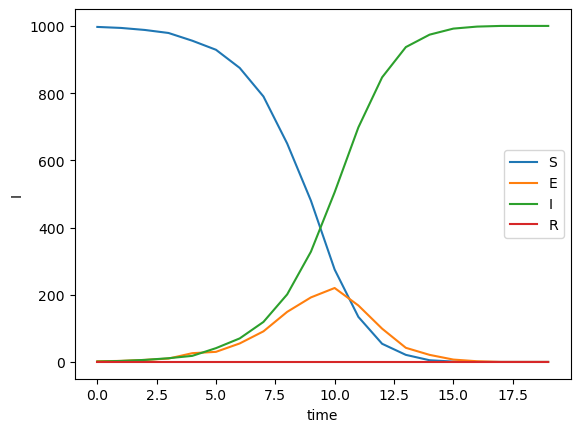

In [28]:
populationNumberPlot= populationNumber.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("I")
plt.legend()